In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# change current working directory before loading custom modules
current_directory = os.getcwd()
home_dir = current_directory.split("notebooks")[0]
data_dir = os.path.join(home_dir, "data")
os.chdir(home_dir)

In [5]:
import os
import pandas as pd

from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold, cross_val_score,
    train_test_split
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, auc, confusion_matrix, f1_score,
                             make_scorer, precision_recall_curve,
                             precision_score, recall_score, matthews_corrcoef
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pickle import dump, load

from tools.preprocessing import ordinal_encoder, scale_data

In [6]:
# read data
df_raw = pd.read_csv(os.path.join(data_dir, "wine-quality-white-and-red.csv"))

### Based on data exploration, prepare data for modelling

In [7]:
# drop perfect duplicates
df_dedup = df_raw.drop_duplicates()
# correct data types
df_dedup["quality"] = df_dedup["quality"].astype("category")
df_dedup["type"] = df_dedup["type"].astype("category")
# check nan
columns_with_nan = df_dedup.isna().any().any(axis=0)
if columns_with_nan:
    raise ValueError("Columns have NAN values")

C:\Users\vnarv\AppData\Local\Temp\ipykernel_19392\477210811.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["quality"] = df_dedup["quality"].astype("category")
C:\Users\vnarv\AppData\Local\Temp\ipykernel_19392\477210811.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dedup["type"] = df_dedup["type"].astype("category")


Note:
- More complex data would require to handle empty values, outliers and highly correlated variables.
- We could think as well of grouping less representative observations into 1 category or transforming numeric variables into categorical variables if they have few categories

In [8]:
target = "type"
df_x = df_dedup.drop(target, axis=1)
df_y = df_dedup[[target]]
df_y["y"] = np.where(df_dedup[target] == 'red', 1, 0)

C:\Users\vnarv\AppData\Local\Temp\ipykernel_19392\1279295188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y["y"] = np.where(df_dedup[target] == 'red', 1, 0)


In [9]:
# split data into train, validation and test, keeping the same proportion for y 
X_train_, X_test, y_train_, y_test = train_test_split(
            df_x, df_y, test_size=0.2, stratify=df_y["y"], random_state=42
        )

X_train, X_val, y_train, y_val = train_test_split(
            X_train_, y_train_, test_size=0.1, stratify=y_train_[target], random_state=42
        )

In [10]:
# check volumes and proportions
for df in [X_train, X_val, X_test, y_train, y_val, y_test]:
    print(df.shape)
for df_y in [y_train, y_val, y_test]: 
    print(df["y"].value_counts(normalize=True))

(3830, 12)
(426, 12)
(1064, 12)
(3830, 2)
(426, 2)
(1064, 2)
0    0.744361
1    0.255639
Name: y, dtype: float64
0    0.744361
1    0.255639
Name: y, dtype: float64
0    0.744361
1    0.255639
Name: y, dtype: float64


In [11]:
# encode the variable "quality" using ordinal encoding
# another option is to transform this variable with one hot encoder
X_train, X_val, X_test = ordinal_encoder(X_train, X_val, X_test,None)
# scale data using 'standard scaler'
X_train, X_val, X_test = scale_data(X_train, X_val, X_test,None)  

(3830, 12)
(3830, 12)
(426, 12)
(426, 12)
(1064, 12)
(1064, 12)


### Test different models with the default parameters
- We could think of the logit model as the base line model

In [12]:
def get_models():
    """Create a dictionary of ML models"""
    seed = 42
    models = {
    # base line model
    "LogisticRegression":
    LogisticRegression(
        random_state=seed,
        #class_weight=cw_dict
    ),
    "SVM":
    SVC(
        #class_weight=cw_dict,
        probability=True
    ),
    "RandomForestClassifier":
        RandomForestClassifier(
            #class_weight=cw_dict,
            random_state=seed,
        ),
    "XGBClassifier":
        XGBClassifier(
            #use_label_encoder=False,
            eval_metric='logloss',
            random_state=seed,
        )
    }
    return models


def cross_validation(model, X, y, scoring):
    """ Perform cross-validation on a given model
    """
    model_scores = []
    for score in scoring:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
        scores = cross_val_score(model, X, y, scoring=score, cv=cv, n_jobs=-1)
        model_scores.append(scores.mean())
    return model_scores


def predict_data(model_name, model, Xtrain, ytrain, X2, y2, do_save):
    """Train a model and optionally save it to a file"""
    model.fit(Xtrain, ytrain)
    if do_save:
        filename = f'{model_name}_model.sav'
        dump(model, open(filename, 'wb'))
    return model.predict(X2)


def compute_metrics(y_true, y_predict, metrics, average=None):
    """Compute several classification metrics"""
    result = dict()
    for metric in metrics:
        if metric == "f1_score":
            score = f1_score(y_true, y_predict, average=average)
            result[metric] = score
        elif metric == "recall":
            score = recall_score(y_true, y_predict, average=average)
            result[metric] = score
        elif metric == "precision":
            score = precision_score(y_true, y_predict, average=average)
            result[metric] = score
    return result


def evaluate_prediction(y_true, y_pred, metrics, graph_cm):
    """Evaluate and display prediction metrics and optionally display the confusion matrix
    """
    metrics_test = compute_metrics(y_true, y_pred, metrics, None)
    for i, j in metrics_test.items():
        print(f"{i}: red {j[0]:.1%}, white {j[1]:.1%}\n\n")
    if graph_cm:
        cm = confusion_matrix(y_test["y"], y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=["red", "white"])
        disp.plot()
        disp.ax_.set_title(name)
        plt.show()

        
def model_precision_recall(model, X, y):
    """Compute precision-recall curve for a model"""
    # predict proba
    yhat = model.predict_proba(X)
    # retrieve probabilities for the positive class
    pos_probs = yhat[:, 1]
    precision, recall, _ = precision_recall_curve(y, pos_probs)
    return precision, recall

LogisticRegression,

**TRAIN**: mattew score: 98.3%, f1 macro 99.2%


**VALIDATION**:
f1_score: red 100.0%, white 100.0%


recall: red 100.0%, white 100.0%


precision: red 100.0%, white 100.0%


**TEST**:
f1_score: red 99.4%, white 98.3%


recall: red 99.4%, white 98.5%


precision: red 99.5%, white 98.2%




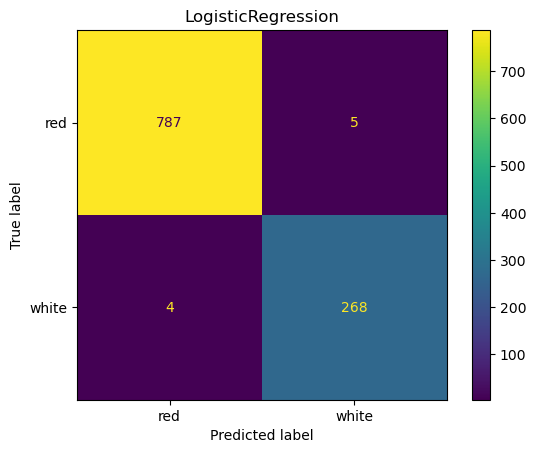

SVM,

**TRAIN**: mattew score: 98.6%, f1 macro 99.3%


**VALIDATION**:
f1_score: red 100.0%, white 100.0%


recall: red 100.0%, white 100.0%


precision: red 100.0%, white 100.0%


**TEST**:
f1_score: red 99.7%, white 99.1%


recall: red 99.9%, white 98.5%


precision: red 99.5%, white 99.6%




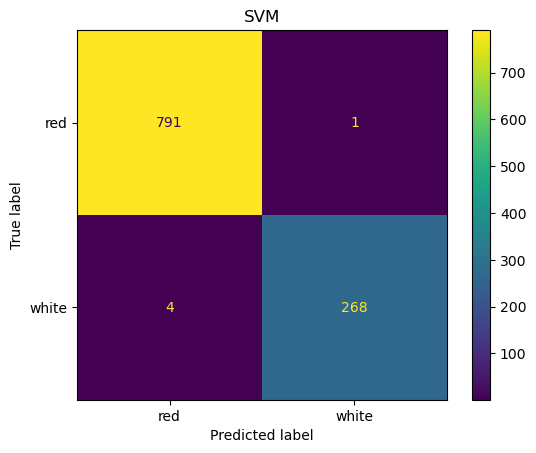

RandomForestClassifier,

**TRAIN**: mattew score: 98.3%, f1 macro 99.1%


**VALIDATION**:
f1_score: red 99.7%, white 99.1%


recall: red 99.7%, white 99.1%


precision: red 99.7%, white 99.1%


**TEST**:
f1_score: red 99.6%, white 98.7%


recall: red 99.9%, white 97.8%


precision: red 99.2%, white 99.6%




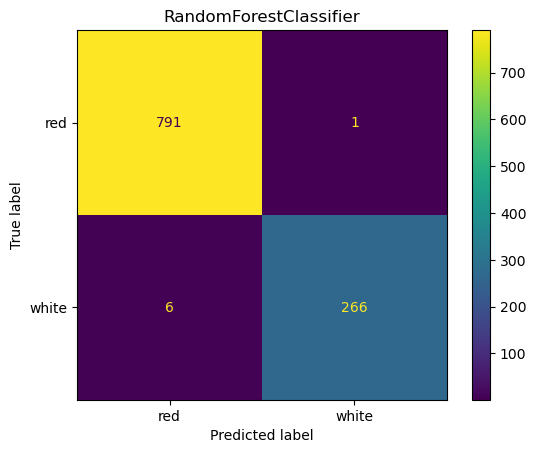

XGBClassifier,

**TRAIN**: mattew score: 98.5%, f1 macro 99.2%


**VALIDATION**:
f1_score: red 99.5%, white 98.6%


recall: red 99.7%, white 98.2%


precision: red 99.4%, white 99.1%


**TEST**:
f1_score: red 99.6%, white 98.7%


recall: red 99.7%, white 98.2%


precision: red 99.4%, white 99.3%




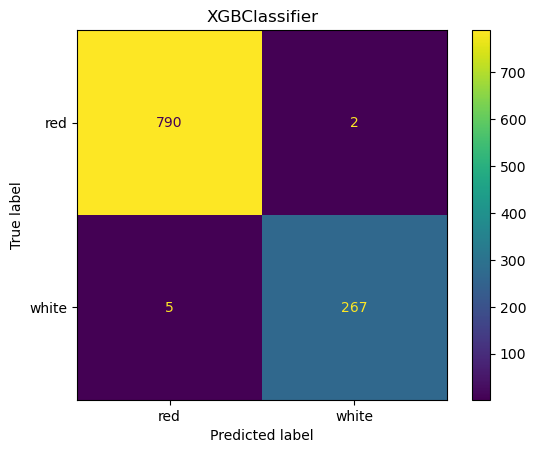

In [13]:
# define a scorer using mattews correlation
mt_score = make_scorer(matthews_corrcoef)

# list of label wise metrics to eavaluate model performance
label_wise_metrics = ["f1_score", "recall", "precision"]

# loop over different models using the get_models function
# Tested models have the default parameters
for name, m in get_models().items():
    
    # Perform cross validation using mattew score and F1 score
    scores = cross_validation(m, X_train, y_train["y"], [mt_score, "f1_macro"])
    # print model performance on the train set
    print(f"{name},\n\n**TRAIN**: mattew score: {scores[0]:.1%}, f1 macro {scores[1]:.1%}\n\n")
    
    # predict validation set and save model to disk
    print("**VALIDATION**:")
    y_val_pred = predict_data(name, m, X_train, y_train["y"], X_val, y_val["y"], do_save=True)
    # Evaluate predictons, using the metrics specify at the begining of the loop
    evaluate_prediction(y_val["y"], y_val_pred, label_wise_metrics, False)
    
    # predict test set and show confusion metrics
    print("**TEST**:")
    # load model
    loaded_model = load(open(f"{name}_model.sav", 'rb'))
    y_test_pred = loaded_model.predict(X_test)
    evaluate_prediction(y_test["y"], y_test_pred, label_wise_metrics, True)
 

- All models show a very good performance. SVM model have the best metrics.

### Precision recall curve for SVM

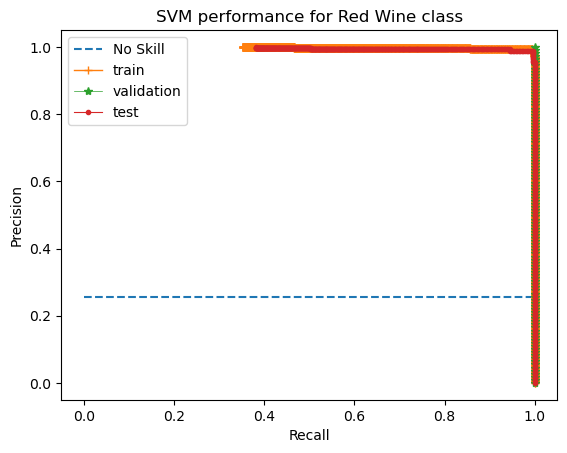

In [14]:
# SVM model
svm_model = load(open(f"SVM_model.sav", 'rb'))

recall_train, precision_train = model_precision_recall(svm_model, X_train, y_train["y"])
recall_val, precision_val = model_precision_recall(svm_model, X_val, y_val["y"])
recall_test, precision_test = model_precision_recall(svm_model, X_test, y_test["y"])
    
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_train[y_train["y"]==1]) / len(y_train)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# plot the model precision-recall curve
plt.plot(recall_train, precision_train, marker='+', label='train', linewidth=1)
plt.plot(recall_val, precision_val, marker='*', label='validation', linewidth=0.5)
plt.plot(recall_test, precision_test, marker='.', label='test', linewidth=0.8)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('SVM performance for Red Wine class')
# show the legend
plt.legend()
# show the plot
plt.show()

### Feature importance
- SVM doesnt have a feature importance attribute, but we can use random forest instead

In [29]:
rf_model = load(open(f"RandomForestClassifier_model.sav", 'rb'))

In [30]:
df_feat_imp = pd.DataFrame(
    data=rf_model.feature_importances_,
    columns=["feat_imp"],
    index=X_train.columns
)
df_feat_imp = df_feat_imp.sort_values("feat_imp", ascending=False)
df_feat_imp

,feat_imp
total sulfur dioxide,0.294869
chlorides,0.260785
volatile acidity,0.134706
density,0.060593
free sulfur dioxide,0.059128
residual sugar,0.054946
fixed acidity,0.044946
sulphates,0.041855
pH,0.020887
citric acid,0.015421


In [28]:
import plotly.express as px
fig = px.bar(df_feat_imp, x='feat_imp', y=df_feat_imp.index, title="Feature importance for Random Forest model")
fig.show()